# feature_selection

El objetivo de este notebook es, una vez generadas las features en `feature_generation` sera elegir cuales son las que mas informacion aportan al modelo, porque hemos generado mas de 300 features, generando una dimensionalidad altisima en nuestro dataset final y seguramente, introduciendo ruido. Eligiendo las mejores k features podremos evitar esto y mejorar resultados.

<hr>

In [1]:
import pandas as pd
import numpy as np
import itertools
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

In [2]:
import nbimporter

import pre_processing
import feature_generation

seed = 7

Importing Jupyter notebook from pre_processing.ipynb
Importing Jupyter notebook from feature_generation.ipynb
Importing Jupyter notebook from feature_selection.ipynb


In [3]:
import lightgbm as lgb
# parametros para lograr buena rapidez
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'max_depth': 7,
    'num_leaves': 80,
    'learning_rate': 0.2,
    'verbose': 0,
    'n_jobs': 2,
    'save_binary': True}

stopping_round = 50
n_estimators=10000

<hr>

# Mejor alternativa para cada categoria
En `feature_generation` generamos muchas features para cada categoria, con distintos metodos. Por ejemplo, en el caso de `tipodepropiedad`, probamos distintos metodos de encoding. Ahora intentaremos ver, mediante un proceso de seleccion rapida, cual es el mejor metodo para cada caso.

Para probar esto de forma factible (porque si quisieramos probar todas las combinaciones esto requeriria muchisimo timepo) vamos a suponer que nuestras categorias de features son independientes (cosa que sabemos que no es verdad) y analizaremos el caso de cada categoria por separado, para luego quedarnos con la mejor alternativa.

El regresor que utilizaremos para obtener la metrica sera **LightGBM** por su grandiosa velocidad y buenos resultados.

<hr>

### Definimos funciones a utilizar:

In [4]:
def top3(a, b, c, d):
    valores = [a,b,c,d]
    first = min(valores, key=lambda x: x[1])
    valores.remove(first)
    second = min(valores, key=lambda x: x[1])
    valores.remove(second)
    third = min(valores, key=lambda x: x[1])
    valores.remove(third)
    return first, second, third

In [5]:
def calcular_mae(subset, categ):    
    train = base.copy()
    
    if (type(subset) == int):
        add = df[features[categ][subset]]
        train = pd.merge(train, add, how='left', on='id')
    elif ((type(subset) == tuple) & (len(subset) > 0)):
        for option in subset:
            add = df[features[categ][option]]
            train = pd.merge(train, add, how='left', on='id')
            
    X = train.drop((['precio']), axis=1).values
    Y = train['precio'].values
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)
    d_train = lgb.Dataset(X_train, label=Y_train)
    d_valid = lgb.Dataset(X_val, label=Y_val)
    watchlist = [d_valid]
    reg = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=False,\
                    early_stopping_rounds = stopping_round)
    Y_pred = reg.predict(X_val)
    return mean_absolute_error(Y_val,Y_pred)

In [6]:
def calcular_best_subsets(categoria, lr=0.2):
    first = ((-1), 999999)
    second = ((-2), 9999999)
    third = ((-3), 99999999)

    params['learning_rate'] = lr
    posibilidades = [i for i in range(len(features[categoria].keys())-1)]
    
    for L in range(0, len(posibilidades)+1):
        for subset in itertools.combinations(posibilidades, L):
            print(subset)
            mae = calcular_mae(subset, categoria)
            current = (subset, mae)
            first, second, third = top3(current, first, second, third)
            
    return (first, second, third)

In [7]:
def imprimir_resultados(x):
    first = x[0]
    second = x[1]
    third = x[2]

    print(f"  | 1 | Combinacion: {first[0]} - MAE: {first[1]}")
    print(f"  | 2 | Combinacion: {second[0]} - MAE: {second[1]}")
    print(f"  | 3 | Combinacion: {third[0]} - MAE: {third[1]}")

### Ejecucion de las pruebas:
Partiremos de un dataset con la informacion basica, al que luego le agregaremos las distintas features.

In [8]:
df,_ = pre_processing.load_featured_datasets()

In [9]:
features = feature_generation.get_features()

In [10]:
base = df[['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales',
           'idzona', 'lat', 'lng', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
           'centroscomercialescercanos', 'precio']].copy()

El proceso sera asi:

Para cada **categoria de feature**, vamos a probar todas las combinaciones entre sus alternativas, para quedarnos con la mejor combinacion de features en cada categoria.
Este es un proceso muy costoso en tiempo, por lo que se corre una vez y se guardan los resultados para ser utilizados directamente. Separaremos el proceso para cada categoria, para que si en una categoria cambiamos features, podamos ejecutar nuevamente la seleccion para dicha categoria.

In [11]:
features.keys()

dict_keys(['metros', 'tipodepropiedad', 'provincia', 'ciudad', 'fecha', 'descripcion', 'metricas', 'habitaciones', 'antiguedad', 'extras', 'volcanes', 'idzona', 'class', 'otros'])

In [12]:
features_selected = {}

<hr>

# Metros

In [12]:
print(datetime.now())

2019-11-19 02:14:03.319867


In [1]:
#%%time
#resultados = calcular_best_subsets('metros')

In [14]:
print(datetime.now())
imprimir_resultados(resultados)

2019-11-19 02:18:39.669611
  | 1 | Combinacion: (0, 1, 2, 3) - MAE: 636670.829008086
  | 2 | Combinacion: (2, 3) - MAE: 637210.7547316124
  | 3 | Combinacion: (0, 2, 3) - MAE: 637587.5465275414


In [13]:
features_selected['metros'] = [(0,1,2,3), (2,3)]

<hr>

# Tipo de propiedad

In [15]:
print(datetime.now())

2019-11-19 02:18:39.677876


In [2]:
#%%time
#resultados = calcular_best_subsets('tipodepropiedad')

In [17]:
print(datetime.now())
imprimir_resultados(resultados)

2019-11-19 02:58:58.177046
  | 1 | Combinacion: (2, 3) - MAE: 610910.0757500499
  | 2 | Combinacion: (0, 1, 2, 4) - MAE: 611011.9991529876
  | 3 | Combinacion: (0, 1, 2) - MAE: 611011.9991529876


In [14]:
features_selected['tipodepropiedad'] = [(2,3), (0,1,2)]

<hr>

# Provincia

In [18]:
print(datetime.now())

2019-11-19 02:58:58.189841


In [3]:
#%%time
#resultados = calcular_best_subsets('provincia')

In [20]:
print(datetime.now())
imprimir_resultados(resultados)

2019-11-19 03:39:51.342462
  | 1 | Combinacion: (3, 4, 5) - MAE: 618267.5602511382
  | 2 | Combinacion: (3, 5) - MAE: 618267.5602511382
  | 3 | Combinacion: (0, 3, 4, 5) - MAE: 618813.3670313193


In [15]:
features_selected['provincia'] = [(3,5), (0,3,4,5)]

<hr>

# Ciudad

In [21]:
print(datetime.now())

2019-11-19 03:39:51.352174


In [4]:
#%%time
#resultados = calcular_best_subsets('ciudad')

In [23]:
print(datetime.now())
imprimir_resultados(resultados)

2019-11-19 03:59:24.905166
  | 1 | Combinacion: (1, 2, 3, 5) - MAE: 601692.8675271927
  | 2 | Combinacion: (0, 2, 3, 5) - MAE: 601872.0072546843
  | 3 | Combinacion: (0, 2, 3, 4, 5) - MAE: 602145.182346223


In [16]:
features_selected['ciudad'] = [(1, 2, 3, 5), (0, 2, 3, 5)]

<hr>

# Fecha

In [24]:
print(datetime.now())

2019-11-19 03:59:24.915204


In [5]:
#%%time
#resultados = calcular_best_subsets('fecha')

In [26]:
print(datetime.now())
imprimir_resultados(resultados)

2019-11-19 06:42:03.164536
  | 1 | Combinacion: (5, 7) - MAE: 605998.596152037
  | 2 | Combinacion: (5, 6) - MAE: 606148.020139398
  | 3 | Combinacion: (7,) - MAE: 606344.7326298917


In [17]:
features_selected['fecha'] = [(5,7), (5,6)]

<hr>

# Descripcion

In [27]:
print(datetime.now())

2019-11-19 06:42:03.175110


In [6]:
#%%time
#resultados = calcular_best_subsets('descripcion')

In [29]:
print(datetime.now())
imprimir_resultados(resultados)

2019-11-19 09:22:15.371072
  | 1 | Combinacion: (0, 1, 4, 5, 6, 8) - MAE: 631227.1441257835
  | 2 | Combinacion: (0, 1, 2, 6, 7, 8) - MAE: 631328.238029824
  | 3 | Combinacion: (0, 1, 2, 5, 6) - MAE: 631665.4840050902


In [18]:
features_selected['descripcion'] = [(0, 1, 4, 5, 6, 8), (0, 1, 2, 6, 7, 8)]

<hr>

# Metricas

In [30]:
print(datetime.now())

2019-11-19 09:22:15.383528


In [7]:
#%%time
#resultados = calcular_best_subsets('metricas')

In [32]:
print(datetime.now())
imprimir_resultados(resultados)

2019-11-19 09:23:20.585960
  | 1 | Combinacion: (0, 1) - MAE: 584996.588460809
  | 2 | Combinacion: (0,) - MAE: 609343.4729995888
  | 3 | Combinacion: (1,) - MAE: 612121.196021603


In [19]:
features_selected['metricas'] = [(0,1), (0,)]

<hr>

# Habitaciones

In [33]:
print(datetime.now())

2019-11-19 09:23:20.594490


In [8]:
#%%time
#resultados = calcular_best_subsets('habitaciones')

In [35]:
print(datetime.now())
imprimir_resultados(resultados)

2019-11-19 09:25:33.942816
  | 1 | Combinacion: (1, 2) - MAE: 639702.7235279069
  | 2 | Combinacion: (2,) - MAE: 639702.7235279069
  | 3 | Combinacion: (1,) - MAE: 639702.7235279069


In [22]:
features_selected['habitaciones'] = [(1,2), (1,)]

<hr>

# Antiguedad

In [36]:
print(datetime.now())

2019-11-19 09:25:33.951315


In [9]:
#%%time
#resultados = calcular_best_subsets('antiguedad')

In [38]:
print(datetime.now())
imprimir_resultados(resultados)

2019-11-19 09:43:19.089943
  | 1 | Combinacion: (0,) - MAE: 638696.0290467282
  | 2 | Combinacion: (1, 2) - MAE: 638938.4152738795
  | 3 | Combinacion: (2,) - MAE: 638938.4152738795


In [23]:
features_selected['antiguedad'] = [(0,), (2,)]

<hr>

# Extras

In [39]:
print(datetime.now())

2019-11-19 09:43:19.100882


In [10]:
#%%time
#resultados = calcular_best_subsets('extras')

In [41]:
print(datetime.now())
imprimir_resultados(resultados)

2019-11-19 09:47:42.226785
  | 1 | Combinacion: (1, 3) - MAE: 607965.9778791349
  | 2 | Combinacion: (1,) - MAE: 609637.5290293088
  | 3 | Combinacion: (0, 1) - MAE: 610674.9637204745


In [24]:
features_selected['extras'] = [(1,3), (1,)]

<hr>

# Volcanes

In [42]:
print(datetime.now())

2019-11-19 09:47:42.236411


In [11]:
#%%time
#resultados = calcular_best_subsets('volcanes')

In [44]:
print(datetime.now())
imprimir_resultados(resultados)

2019-11-19 09:48:54.050882
  | 1 | Combinacion: (0,) - MAE: 639601.9486926179
  | 2 | Combinacion: (0, 1) - MAE: 640206.3664188283
  | 3 | Combinacion: (1,) - MAE: 640206.3664188283


In [25]:
features_selected['volcanes'] = [(0,), (0,1)]

<hr>

# ID Zona

In [45]:
print(datetime.now())

2019-11-19 09:48:54.059466


In [12]:
#%%time
#resultados = calcular_best_subsets('idzona')

In [47]:
print(datetime.now())
imprimir_resultados(resultados)

2019-11-19 09:57:29.245997
  | 1 | Combinacion: (0, 1, 4) - MAE: 570372.429341848
  | 2 | Combinacion: (0, 1, 3) - MAE: 570437.0901833787
  | 3 | Combinacion: (0, 4) - MAE: 571177.1939581885


In [26]:
features_selected['idzona'] = [(0,1,4), (0,1,3)]

<hr>
Como dijimos anteriormente por tratarse de un proceso costoso, hardcodeamos los resultados obtenidos para poder utilizarlos sin tener que correr nuevamente este notebook:

In [17]:
def get_selected_dataframe_2(df, precio=True, aniomes=False):
    features = feature_generation.get_features()
    
    base = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales',
           'idzona', 'lat', 'lng', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
           'centroscomercialescercanos']
    
    selection = {'metros':[0,1,2,3],
                 'tipodepropiedad':[2,3],
                 'provincia':[0,3,4],
                 'ciudad':[1,2,3],
                 'fecha':[5,6],
                 'descripcion':[0,1,4,5,6,8],
                 'metricas':[0,1],
                 'habitaciones':[0],
                 'antiguedad':[0],
                 'extras':[1,3],
                 'volcanes':[0],
                 'idzona':[0,1,4],
                 #'class':[0,1],
                 #'otros':[0,1],
                 'metrocuadrado':[0]
                }
    append = []
    
    for categoria in selection.keys():
        for opcion in selection[categoria]:
            append += features[categoria][opcion]
    
    if precio:
        append += ['precio']
    
    if aniomes:
        append += ['aniomes']
    
    return df[base + append]    

In [10]:
def get_selected_dataframe(df, precio=True, aniomes=False):
    features = feature_generation.get_features()
    
    base = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales',
           'idzona', 'lat', 'lng', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
           'centroscomercialescercanos']
    
    selection = {'metros':[0,1,2,3],
                 'tipodepropiedad':[2,3],
                 'provincia':[3,5],
                 'ciudad':[1,2,3,5],
                 'fecha':[5,7],
                 'descripcion':[0,1,4,5,6,8],
                 'metricas':[0,1],
                 'habitaciones':[1,2],
                 'antiguedad':[0],
                 'extras':[1,3],
                 'volcanes':[0],
                 'idzona':[0,1,4],
                 #'class':[0,1],
                 #'otros':[0,1],
                 'metrocuadrado':[0]
                }
    append = []
    
    for categoria in selection.keys():
        for opcion in selection[categoria]:
            append += features[categoria][opcion]
    
    if precio:
        append += ['precio']
    
    if aniomes:
        append += ['aniomes']
    
    return df[base + append]    

In [4]:
def get_full_selected_dataframe(df, precio=True, aniomes=False):
    """A diferencia del caso anterior, en esta funcion devolveremos un dataframe con muchas mas features,
    solamente seleccionando en las categorias que debian ser encodeadas."""
    
    features = feature_generation.get_features()
    
    base = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales',
           'idzona', 'lat', 'lng', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
           'centroscomercialescercanos']
    
    selection = {'metros':['all'],
                 'tipodepropiedad':[2,3],
                 'provincia':[3,5],
                 'ciudad':[1,2,3,5],
                 'fecha':['all'],
                 'descripcion':['all'],
                 'metricas':['all'],
                 'habitaciones':[1,2],
                 'antiguedad':[0],
                 'extras':['all'],
                 'volcanes':['all'],
                 'idzona':['all'],
                 #'class':[0,1],
                 'otros':['all']
                }
    append = []
    
    for categoria in selection.keys():
        for opcion in selection[categoria]:
            append += features[categoria][opcion]
    
    if precio:
        append += ['precio']
    
    if aniomes:
        append += ['aniomes']
    
    return df[base + append]    

# Feature Importance

In [7]:
import lightgbm as lgb
# parametros para lograr buena rapidez
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'max_depth': 7,
    'num_leaves': 80,
    'learning_rate': 0.2,
    'verbose': 0,
    'early_stopping_round': 50,
    'n_jobs': 2,
    'save_binary': True}
n_estimators=10000

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances-01.png')
    plt.show()
    
def plotImp_xgb(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances-01.png')
    plt.show()

In [8]:
train,_ = pre_processing.load_featured_datasets()

In [9]:
features = feature_generation.get_features()

In [10]:
train = get_selected_dataframe(train)

In [11]:
train.shape

(240000, 142)

In [12]:
X = train.drop((['precio']), axis=1).values
Y = train['precio'].values

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)

d_train = lgb.Dataset(X_train, label=Y_train)
d_valid = lgb.Dataset(X_val, label=Y_val)
watchlist = [d_valid]
reg = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 1.36555e+06
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l1: 1.17874e+06
[3]	valid_0's l1: 1.03513e+06
[4]	valid_0's l1: 925414
[5]	valid_0's l1: 843234
[6]	valid_0's l1: 781509
[7]	valid_0's l1: 733297
[8]	valid_0's l1: 694368
[9]	valid_0's l1: 664939
[10]	valid_0's l1: 642720
[11]	valid_0's l1: 623031
[12]	valid_0's l1: 607789
[13]	valid_0's l1: 595526
[14]	valid_0's l1: 585749
[15]	valid_0's l1: 578808
[16]	valid_0's l1: 573347
[17]	valid_0's l1: 569151
[18]	valid_0's l1: 565029
[19]	valid_0's l1: 560526
[20]	valid_0's l1: 557539
[21]	valid_0's l1: 555043
[22]	valid_0's l1: 553340
[23]	valid_0's l1: 551763
[24]	valid_0's l1: 550156
[25]	valid_0's l1: 547517
[26]	valid_0's l1: 546218
[27]	valid_0's l1: 545253
[28]	valid_0's l1: 543403
[29]	valid_0's l1: 541850
[30]	valid_0's l1: 540634
[31]	valid_0's l1: 539423
[32]	valid_0's l1: 538489
[33]	valid_0's l1: 537520
[34]	valid_0's l1: 536422
[35]	valid_0's l1: 535706
[36]	valid_0's l1: 5350

[310]	valid_0's l1: 494655
[311]	valid_0's l1: 494649
[312]	valid_0's l1: 494597
[313]	valid_0's l1: 494618
[314]	valid_0's l1: 494576
[315]	valid_0's l1: 494559
[316]	valid_0's l1: 494480
[317]	valid_0's l1: 494398
[318]	valid_0's l1: 494329
[319]	valid_0's l1: 494318
[320]	valid_0's l1: 494217
[321]	valid_0's l1: 494214
[322]	valid_0's l1: 494144
[323]	valid_0's l1: 494070
[324]	valid_0's l1: 494059
[325]	valid_0's l1: 493976
[326]	valid_0's l1: 494049
[327]	valid_0's l1: 494048
[328]	valid_0's l1: 493881
[329]	valid_0's l1: 493853
[330]	valid_0's l1: 493883
[331]	valid_0's l1: 493679
[332]	valid_0's l1: 493668
[333]	valid_0's l1: 493655
[334]	valid_0's l1: 493751
[335]	valid_0's l1: 493707
[336]	valid_0's l1: 493528
[337]	valid_0's l1: 493539
[338]	valid_0's l1: 493520
[339]	valid_0's l1: 493452
[340]	valid_0's l1: 493399
[341]	valid_0's l1: 493390
[342]	valid_0's l1: 493404
[343]	valid_0's l1: 493316
[344]	valid_0's l1: 493182
[345]	valid_0's l1: 493141
[346]	valid_0's l1: 493096
[

[618]	valid_0's l1: 488595
[619]	valid_0's l1: 488568
[620]	valid_0's l1: 488551
[621]	valid_0's l1: 488542
[622]	valid_0's l1: 488599
[623]	valid_0's l1: 488581
[624]	valid_0's l1: 488625
[625]	valid_0's l1: 488617
[626]	valid_0's l1: 488573
[627]	valid_0's l1: 488544
[628]	valid_0's l1: 488561
[629]	valid_0's l1: 488555
[630]	valid_0's l1: 488538
[631]	valid_0's l1: 488445
[632]	valid_0's l1: 488443
[633]	valid_0's l1: 488438
[634]	valid_0's l1: 488355
[635]	valid_0's l1: 488343
[636]	valid_0's l1: 488383
[637]	valid_0's l1: 488338
[638]	valid_0's l1: 488338
[639]	valid_0's l1: 488286
[640]	valid_0's l1: 488264
[641]	valid_0's l1: 488290
[642]	valid_0's l1: 488298
[643]	valid_0's l1: 488212
[644]	valid_0's l1: 488198
[645]	valid_0's l1: 488236
[646]	valid_0's l1: 488228
[647]	valid_0's l1: 488131
[648]	valid_0's l1: 488156
[649]	valid_0's l1: 488140
[650]	valid_0's l1: 488152
[651]	valid_0's l1: 488176
[652]	valid_0's l1: 488170
[653]	valid_0's l1: 488125
[654]	valid_0's l1: 488133
[

[927]	valid_0's l1: 485643
[928]	valid_0's l1: 485656
[929]	valid_0's l1: 485663
[930]	valid_0's l1: 485623
[931]	valid_0's l1: 485602
[932]	valid_0's l1: 485612
[933]	valid_0's l1: 485608
[934]	valid_0's l1: 485584
[935]	valid_0's l1: 485594
[936]	valid_0's l1: 485582
[937]	valid_0's l1: 485546
[938]	valid_0's l1: 485545
[939]	valid_0's l1: 485543
[940]	valid_0's l1: 485542
[941]	valid_0's l1: 485546
[942]	valid_0's l1: 485515
[943]	valid_0's l1: 485499
[944]	valid_0's l1: 485568
[945]	valid_0's l1: 485504
[946]	valid_0's l1: 485499
[947]	valid_0's l1: 485507
[948]	valid_0's l1: 485494
[949]	valid_0's l1: 485489
[950]	valid_0's l1: 485458
[951]	valid_0's l1: 485435
[952]	valid_0's l1: 485434
[953]	valid_0's l1: 485437
[954]	valid_0's l1: 485427
[955]	valid_0's l1: 485429
[956]	valid_0's l1: 485420
[957]	valid_0's l1: 485417
[958]	valid_0's l1: 485411
[959]	valid_0's l1: 485420
[960]	valid_0's l1: 485415
[961]	valid_0's l1: 485424
[962]	valid_0's l1: 485431
[963]	valid_0's l1: 485444
[

[1224]	valid_0's l1: 484257
[1225]	valid_0's l1: 484307
[1226]	valid_0's l1: 484312
[1227]	valid_0's l1: 484300
[1228]	valid_0's l1: 484296
[1229]	valid_0's l1: 484297
[1230]	valid_0's l1: 484280
[1231]	valid_0's l1: 484276
[1232]	valid_0's l1: 484288
[1233]	valid_0's l1: 484286
[1234]	valid_0's l1: 484256
[1235]	valid_0's l1: 484258
[1236]	valid_0's l1: 484253
[1237]	valid_0's l1: 484249
[1238]	valid_0's l1: 484228
[1239]	valid_0's l1: 484215
[1240]	valid_0's l1: 484216
[1241]	valid_0's l1: 484200
[1242]	valid_0's l1: 484225
[1243]	valid_0's l1: 484218
[1244]	valid_0's l1: 484217
[1245]	valid_0's l1: 484217
[1246]	valid_0's l1: 484258
[1247]	valid_0's l1: 484243
[1248]	valid_0's l1: 484240
[1249]	valid_0's l1: 484248
[1250]	valid_0's l1: 484215
[1251]	valid_0's l1: 484182
[1252]	valid_0's l1: 484162
[1253]	valid_0's l1: 484177
[1254]	valid_0's l1: 484172
[1255]	valid_0's l1: 484183
[1256]	valid_0's l1: 484196
[1257]	valid_0's l1: 484200
[1258]	valid_0's l1: 484201
[1259]	valid_0's l1:

In [13]:
Y_pred = reg.predict(X_val)
print(mean_absolute_error(Y_val,Y_pred))

483803.0140935417


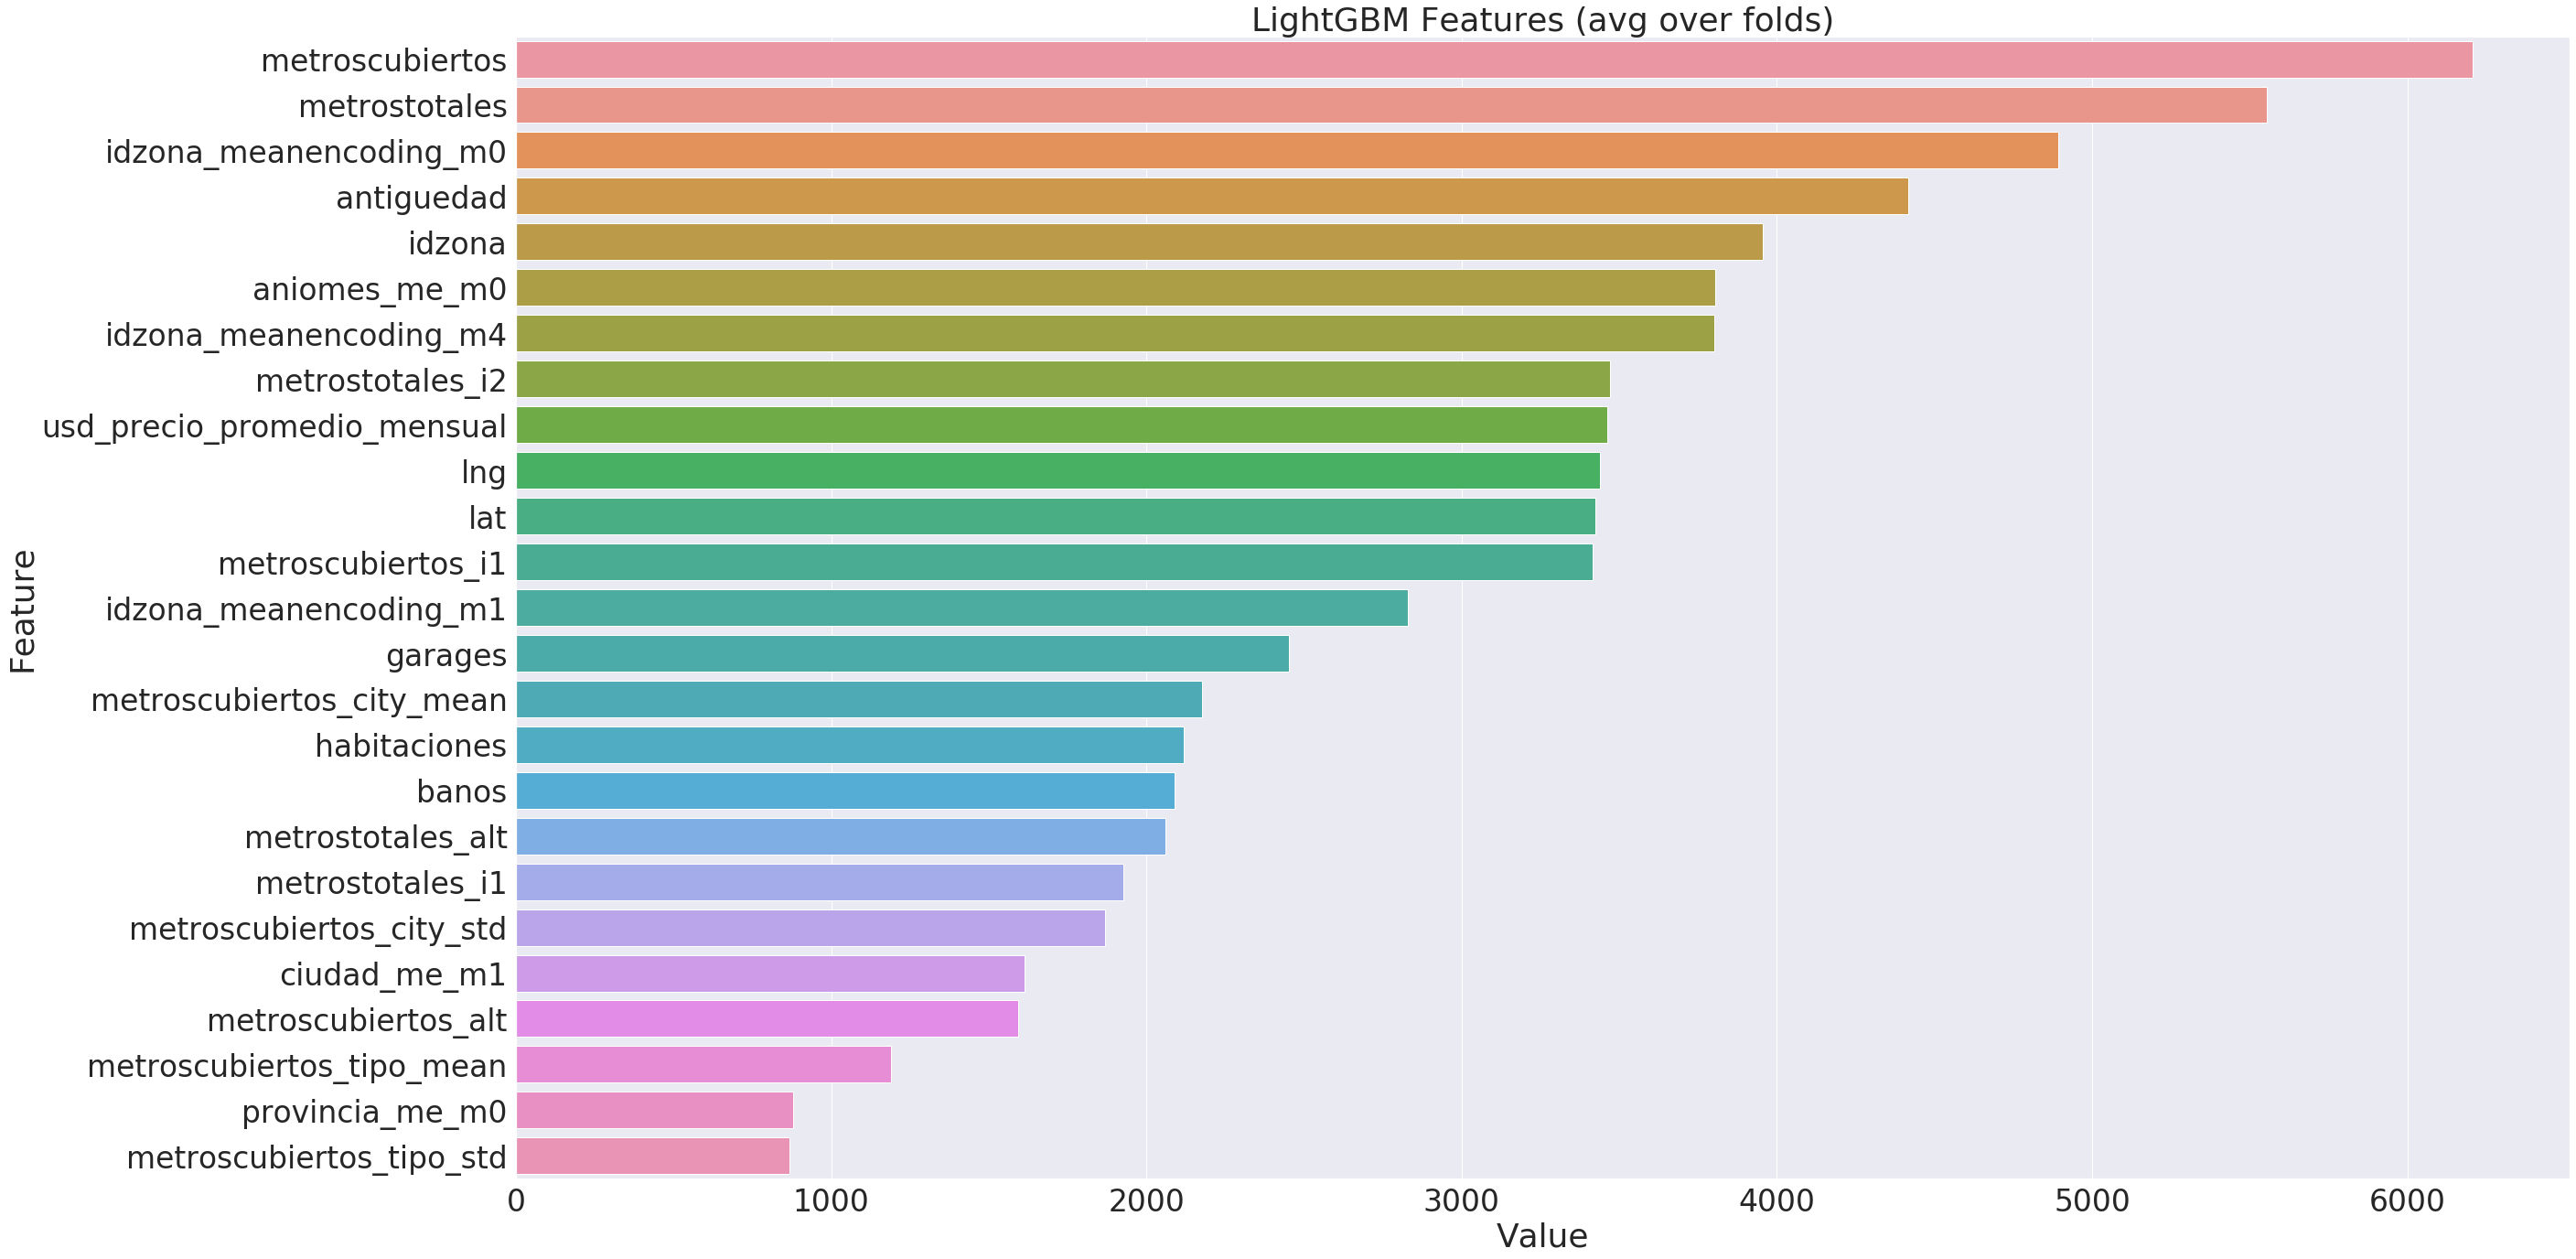

In [31]:
plotImp(reg, train.drop((['precio']), axis=1), 25)

In [32]:
# Vemos para XGBoost

In [33]:
import xgboost

X = train.drop('precio', axis=1).values
Y = train['precio'].values

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [34]:
reg = xgboost.XGBRegressor(max_depth=12,n_estimators=140 ,learning_rate=0.08, verbosity=2,subsample=0.9, min_child_weight=20, n_jobs=2)
reg.fit(X_train,Y_train)

[00:20:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:20:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2886 extra nodes, 0 pruned nodes, max_depth=12
[00:20:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3088 extra nodes, 0 pruned nodes, max_depth=12
[00:20:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3104 extra nodes, 0 pruned nodes, max_depth=12
[00:20:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3034 extra nodes, 0 pruned nodes, max_depth=12
[00:20:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3280 extra nodes, 0 pruned nodes, max_depth=12
[00:20:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3374 extra nodes, 0 pruned nodes, max_depth=12
[00:20:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:22:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1048 extra nodes, 0 pruned nodes, max_depth=12
[00:22:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1018 extra nodes, 0 pruned nodes, max_depth=12
[00:22:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 976 extra nodes, 0 pruned nodes, max_depth=12
[00:22:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 856 extra nodes, 0 pruned nodes, max_depth=12
[00:22:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1156 extra nodes, 0 pruned nodes, max_depth=12
[00:22:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 992 extra nodes, 0 pruned nodes, max_depth=12
[00:22:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1164 extra nodes, 0 pruned nodes, max_depth=12
[00:22:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 r

[00:24:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 606 extra nodes, 0 pruned nodes, max_depth=12
[00:24:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 710 extra nodes, 0 pruned nodes, max_depth=12
[00:24:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=12
[00:24:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 656 extra nodes, 0 pruned nodes, max_depth=12
[00:24:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 636 extra nodes, 0 pruned nodes, max_depth=12
[00:24:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=12
[00:24:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 538 extra nodes, 0 pruned nodes, max_depth=12
[00:24:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=12, min_child_weight=20, missing=None, n_estimators=140,
             n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=2)

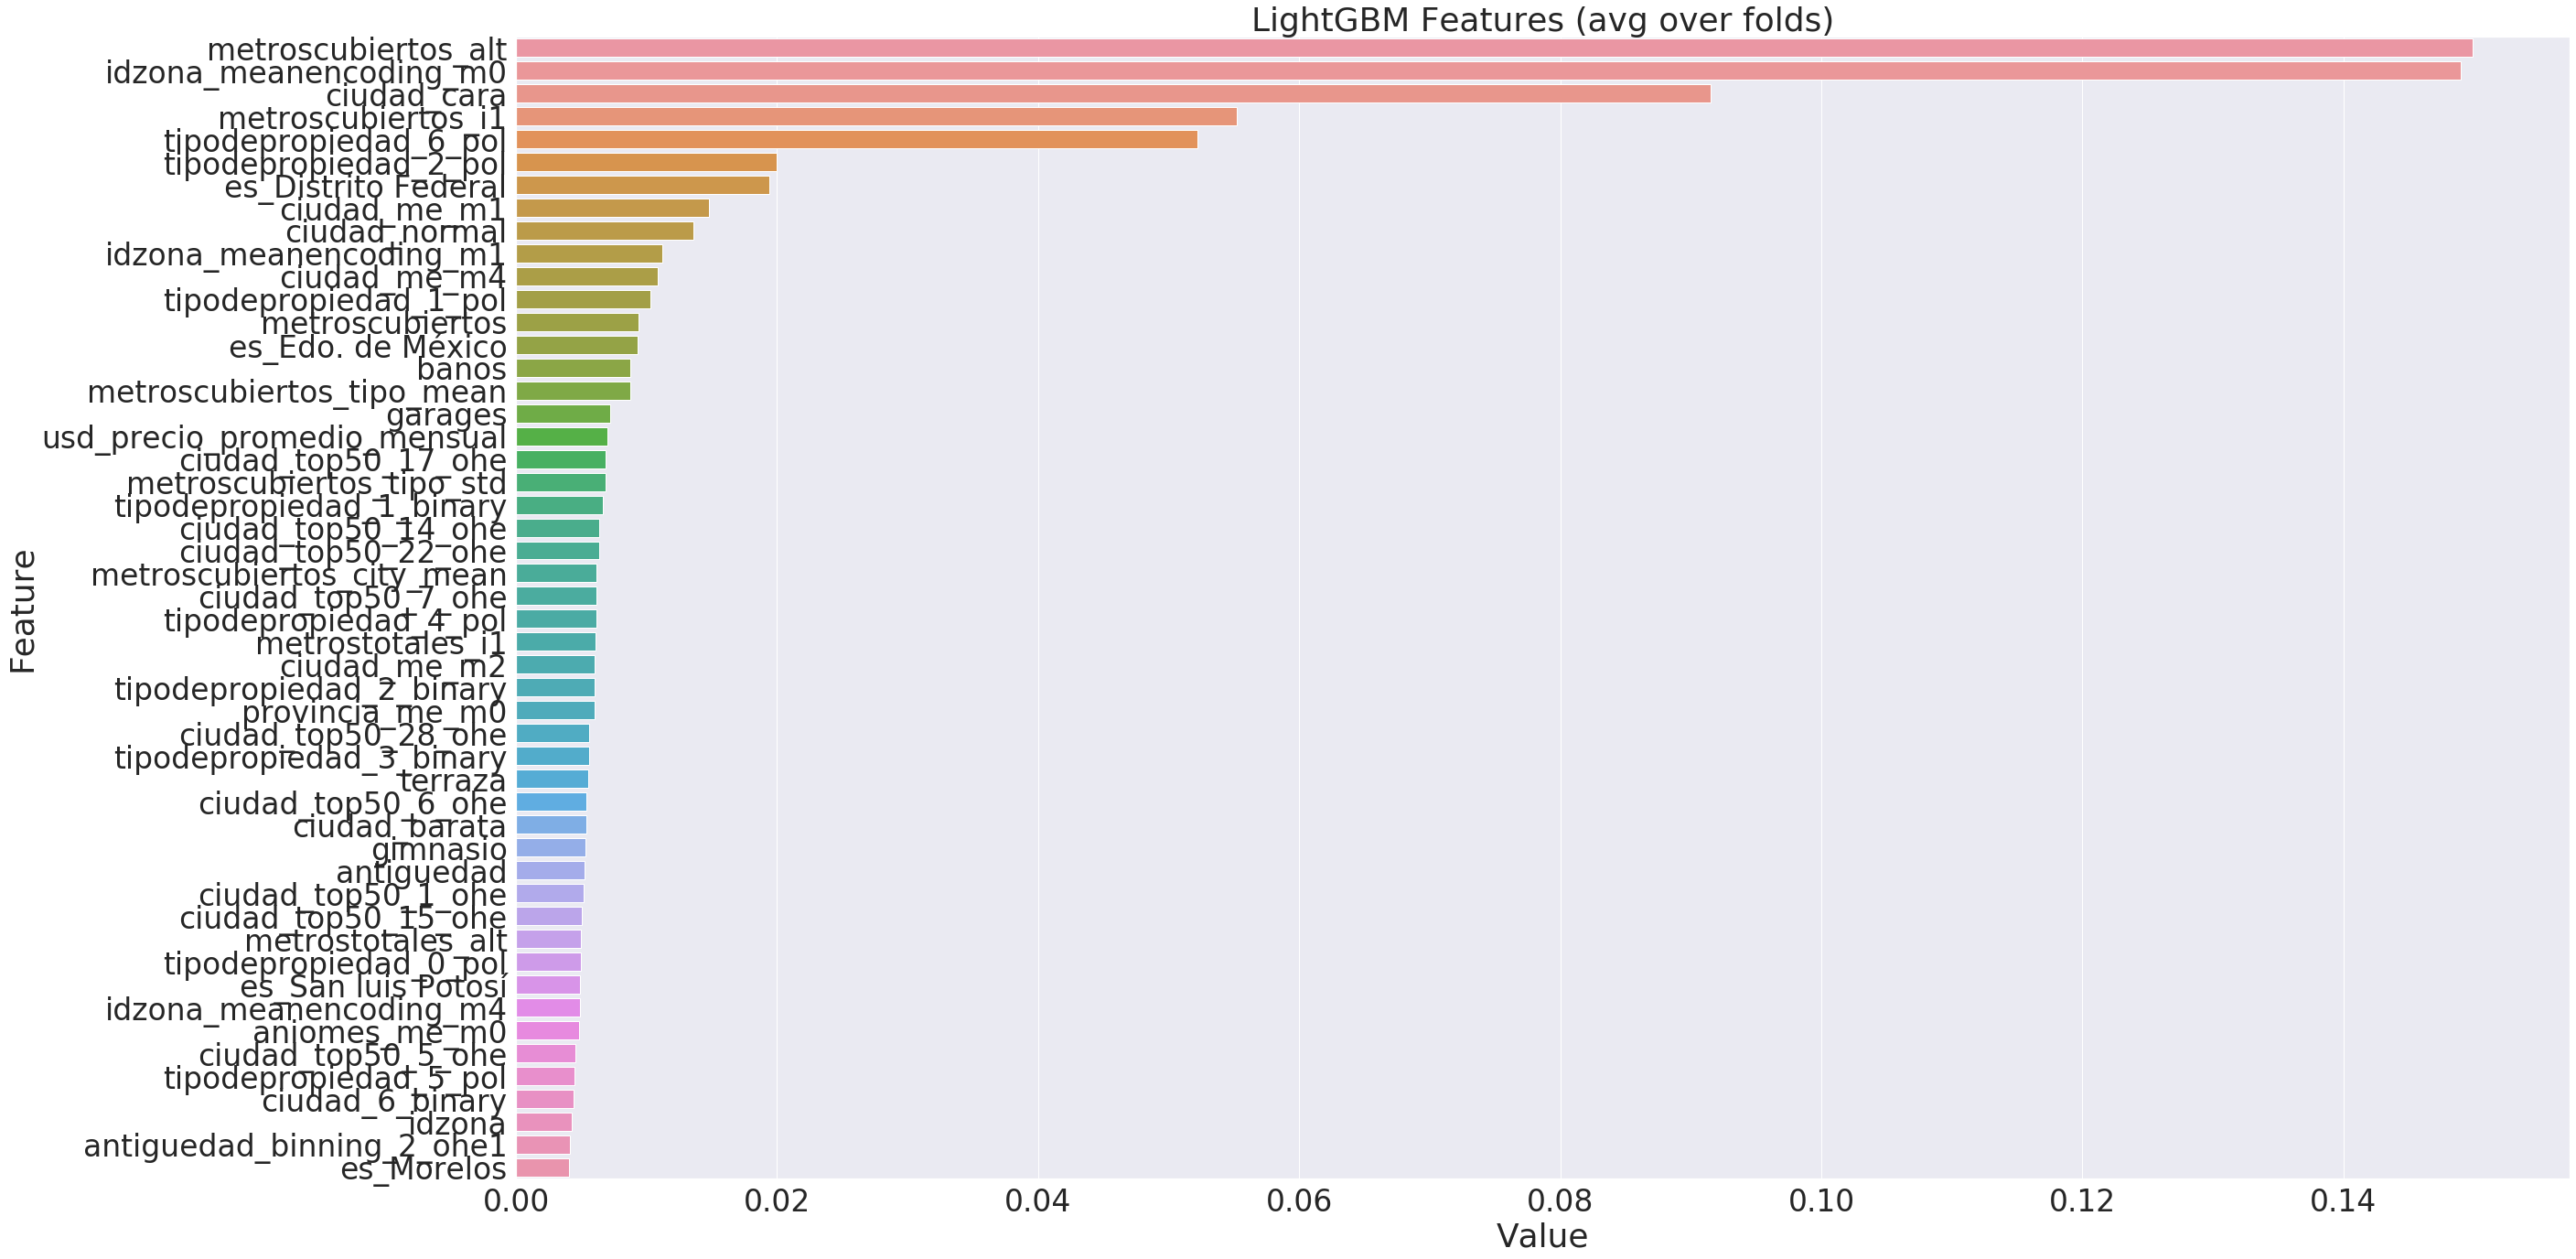

In [37]:
plotImp_xgb(reg, train.drop((['precio']), axis=1), 50)

<hr>

# Distintos algoritmos de Feature Selection
Si bien los resultados mejoraron considerablemente al probar esta estrategia 'greedy' de armado de posibles combinaciones, ahora vamos a utilizar distintos algoritmos para quedarnos con los features que mejor MAE obtengan.
Por tratarse de un proceso sumamente costoso, la idea es ejecutarlo una vez y luego guardar los resultados.

Usamos Random Forest por su conocida estabilidad para **feature importance**.

In [5]:
df,_ = pre_processing.load_featured_datasets()
features = feature_generation.get_features()
df = get_full_selected_dataframe(df)

# Cumulative Importance

In [6]:
from sklearn.ensemble import RandomForestRegressor

In [7]:
# Imputando nulos con mean
train = df.fillna(df.mean())

In [8]:
X = train.drop('precio', axis=1).values
Y = train['precio'].values
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

In [9]:
reg = RandomForestRegressor(n_estimators = 200, random_state = seed, verbose=2,
                            max_depth=10, n_jobs=3) 
reg.fit(X_train, Y_train)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 200
building tree 2 of 200building tree 3 of 200

building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.5min


building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80

[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  6.1min


building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200


[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:  7.8min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=3,
                      oob_score=False, random_state=7, verbose=2,
                      warm_start=False)

In [40]:
names = train.columns.to_list()
sorted_features = (sorted(zip(map(lambda x: round(x, 4), reg.feature_importances_), names), reverse=True))
sorted_features = pd.DataFrame(sorted_features)[1].to_list()

In [41]:
lista_progresiva = [sorted_features[:i] for i in range(1,len(sorted_features))]

In [45]:
len(lista_progresiva)

163

In [46]:
# Tenemos que realizar 163 corridas del algoritmo para detectar el mejor resultado posible para este algoritmo.

In [92]:
Y = train['precio'].values

best_mae = 99999999999
last_mae = 99999999999
features_grosos = []
features_muy_grosos = []

for i, features in enumerate(lista_progresiva):
    print(f"Iteración {i+1} de {len(lista_progresiva)}")
    start = datetime.now()
    
    train_i = train[features] 
    X = train_i.values
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
    
    reg = RandomForestRegressor(n_estimators = 100, random_state=seed, verbose=0, max_depth=10, n_jobs=3)
    reg.fit(X_train, Y_train)
    
    y_pred = reg.predict(X_val)
    mae = metrics.mean_absolute_error(Y_val, y_pred)
    
    if (mae<last_mae):
        features_grosos.append(features[-1])
    
    if (mae<best_mae):
        best_mae = mae
        best_features = features
        features_muy_grosos.append(features[-1])
    
    last_mae = mae
    
    stop = datetime.now()
    time = (stop-start).seconds
    
    print(f"MAE: {int(mae)} | Mejor MAE hasta el momento: {int(best_mae)} (i={len(best_features)}).")
    print(f"Tiempo: {time} segundos - ({round((time/60),2)} minutos) - ({round((time/3600),2)} horas).\n")
    

Iteración 1 de 163
MAE: 982890 | Mejor MAE hasta el momento: 982890 (i=1).
Tiempo: 7 segundos - (0.12 minutos) - (0.0 horas).

Iteración 2 de 163
MAE: 739676 | Mejor MAE hasta el momento: 739676 (i=2).
Tiempo: 9 segundos - (0.15 minutos) - (0.0 horas).

Iteración 3 de 163
MAE: 738859 | Mejor MAE hasta el momento: 738859 (i=3).
Tiempo: 12 segundos - (0.2 minutos) - (0.0 horas).

Iteración 4 de 163
MAE: 697407 | Mejor MAE hasta el momento: 697407 (i=4).
Tiempo: 12 segundos - (0.2 minutos) - (0.0 horas).

Iteración 5 de 163
MAE: 687101 | Mejor MAE hasta el momento: 687101 (i=5).
Tiempo: 15 segundos - (0.25 minutos) - (0.0 horas).

Iteración 6 de 163
MAE: 668534 | Mejor MAE hasta el momento: 668534 (i=6).
Tiempo: 15 segundos - (0.25 minutos) - (0.0 horas).

Iteración 7 de 163
MAE: 642279 | Mejor MAE hasta el momento: 642279 (i=7).
Tiempo: 20 segundos - (0.33 minutos) - (0.01 horas).

Iteración 8 de 163
MAE: 637011 | Mejor MAE hasta el momento: 637011 (i=8).
Tiempo: 21 segundos - (0.35 minu

MAE: 592195 | Mejor MAE hasta el momento: 588134 (i=62).
Tiempo: 136 segundos - (2.27 minutos) - (0.04 horas).

Iteración 65 de 163
MAE: 599491 | Mejor MAE hasta el momento: 588134 (i=62).
Tiempo: 137 segundos - (2.28 minutos) - (0.04 horas).

Iteración 66 de 163
MAE: 594482 | Mejor MAE hasta el momento: 588134 (i=62).
Tiempo: 139 segundos - (2.32 minutos) - (0.04 horas).

Iteración 67 de 163
MAE: 588410 | Mejor MAE hasta el momento: 588134 (i=62).
Tiempo: 139 segundos - (2.32 minutos) - (0.04 horas).

Iteración 68 de 163
MAE: 597255 | Mejor MAE hasta el momento: 588134 (i=62).
Tiempo: 141 segundos - (2.35 minutos) - (0.04 horas).

Iteración 69 de 163
MAE: 592736 | Mejor MAE hasta el momento: 588134 (i=62).
Tiempo: 141 segundos - (2.35 minutos) - (0.04 horas).

Iteración 70 de 163
MAE: 586364 | Mejor MAE hasta el momento: 586364 (i=70).
Tiempo: 143 segundos - (2.38 minutos) - (0.04 horas).

Iteración 71 de 163
MAE: 591453 | Mejor MAE hasta el momento: 586364 (i=70).
Tiempo: 143 segundo

MAE: 593129 | Mejor MAE hasta el momento: 586364 (i=70).
Tiempo: 191 segundos - (3.18 minutos) - (0.05 horas).

Iteración 127 de 163
MAE: 595776 | Mejor MAE hasta el momento: 586364 (i=70).
Tiempo: 190 segundos - (3.17 minutos) - (0.05 horas).

Iteración 128 de 163
MAE: 590918 | Mejor MAE hasta el momento: 586364 (i=70).
Tiempo: 189 segundos - (3.15 minutos) - (0.05 horas).

Iteración 129 de 163
MAE: 591460 | Mejor MAE hasta el momento: 586364 (i=70).
Tiempo: 191 segundos - (3.18 minutos) - (0.05 horas).

Iteración 130 de 163
MAE: 593409 | Mejor MAE hasta el momento: 586364 (i=70).
Tiempo: 192 segundos - (3.2 minutos) - (0.05 horas).

Iteración 131 de 163
MAE: 595267 | Mejor MAE hasta el momento: 586364 (i=70).
Tiempo: 192 segundos - (3.2 minutos) - (0.05 horas).

Iteración 132 de 163
MAE: 595925 | Mejor MAE hasta el momento: 586364 (i=70).
Tiempo: 195 segundos - (3.25 minutos) - (0.05 horas).

Iteración 133 de 163
MAE: 595744 | Mejor MAE hasta el momento: 586364 (i=70).
Tiempo: 192 se

In [93]:
print(best_features)

['idzona_meanencoding_m0', 'metroscubiertos_alt', 'metroscubiertos_i1', 'tipodepropiedad_6_pol', 'metroscubiertos', 'ciudad_cara', 'timestamp_scaled', 'tipodepropiedad_2_pol', 'idzona', 'timestamp', 'antiguedad', 'ciudad_me_m4', 'metroscubiertos_city_mean', 'provincia_me_m0', 'metrostotales_i1', 'idzona_meanencoding_m1', 'banos', 'metrostotales_alt', 'ciudad_me_m1', 'ciudad_me_m3', 'ciudad_me_m2', 'metroscubiertos_tipo_mean', 'idzona_meanencoding_m4', 'garages', 'precio_promedio_metrocubierto_aniomes', 'idzona_meanencoding_m2', 'metroscubiertos_city_std', 'metrostotales_i2', 'metrostotales', 'idzona_meanencoding_m3', 'es_Distrito Federal', 'metroscubiertos_tipo_std', 'lng', 'usd_precio_promedio_mensual', 'lat', 'ciudad_normal', 'habitaciones', 'aniomes_me_m3', 'tipodepropiedad_0_pol', 'es_Edo. de México', 'dia_featured', 'aniomes_me_m4', 'aniomes_me_m2', 'aniomes_me_m1', 'aniomes_me_m0', 'usd_variacion_mes_anterior', 'tipodepropiedad_3_pol', 'ciudad_6_binary', 'usd_variacion', 'tipodep

In [94]:
print(features_grosos)

['idzona_meanencoding_m0', 'metroscubiertos_alt', 'metroscubiertos_i1', 'tipodepropiedad_6_pol', 'metroscubiertos', 'ciudad_cara', 'timestamp_scaled', 'tipodepropiedad_2_pol', 'idzona', 'antiguedad', 'ciudad_me_m4', 'metroscubiertos_city_mean', 'provincia_me_m0', 'banos', 'ciudad_me_m1', 'ciudad_me_m2', 'garages', 'precio_promedio_metrocubierto_aniomes', 'idzona_meanencoding_m2', 'metroscubiertos_city_std', 'metrostotales_i2', 'es_Distrito Federal', 'metroscubiertos_tipo_std', 'lat', 'habitaciones', 'tipodepropiedad_0_pol', 'es_Edo. de México', 'aniomes_me_m4', 'aniomes_me_m2', 'aniomes_me_m0', 'tipodepropiedad_3_pol', 'usd_variacion', 'tipodepropiedad_1_pol', 'antiguedad_binning_1_ohe1', 'aniomes', 'tipodepropiedad_2_binary', 'vigilancia', 'mes_featured', 'mes', 'ciudad_top50_1_ohe', 'ciudad_7_binary', 'antiguedad_binning_3_ohe1', 'antiguedad_binning_2_ohe1', 'tipodepropiedad_5_pol', 'tipodepropiedad_3_binary', 'metrostotales_confiables_alt', 'lujo', 'hab_binning_me_m3', 'hab_binning_

In [95]:
print(features_muy_grosos)

['idzona_meanencoding_m0', 'metroscubiertos_alt', 'metroscubiertos_i1', 'tipodepropiedad_6_pol', 'metroscubiertos', 'ciudad_cara', 'timestamp_scaled', 'tipodepropiedad_2_pol', 'idzona', 'antiguedad', 'ciudad_me_m4', 'metroscubiertos_city_mean', 'provincia_me_m0', 'banos', 'ciudad_me_m2', 'metroscubiertos_city_std', 'metrostotales_i2', 'aniomes', 'mes', 'antiguedad_binning_2_ohe1', 'ciudad_top50_27_ohe']


In [101]:
# Repetimos el proceso para las listas de features_grosos, teniendo en cuenta que quizas
# eliminamos aun mas ruido.

In [97]:
lista_progresiva_2 = [features_grosos[:i] for i in range(1,len(features_grosos))]

In [98]:
Y = train['precio'].values

best_mae_2 = 99999999999
last_mae = 99999999999
features_grosos_2 = []
features_muy_grosos_2 = []

for i, features in enumerate(lista_progresiva_2):
    print(f"Iteración {i+1} de {len(lista_progresiva_2)}")
    start = datetime.now()
    
    train_i = train[features] 
    X = train_i.values
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
    
    reg = RandomForestRegressor(n_estimators = 100, random_state=seed, verbose=0, max_depth=10, n_jobs=3)
    reg.fit(X_train, Y_train)
    
    y_pred = reg.predict(X_val)
    mae = metrics.mean_absolute_error(Y_val, y_pred)
    
    if (mae<last_mae):
        features_grosos_2.append(features[-1])
    
    if (mae<best_mae_2):
        best_mae_2 = mae
        best_features_2 = features
        features_muy_grosos_2.append(features[-1])
    
    last_mae = mae
    
    stop = datetime.now()
    time = (stop-start).seconds
    
    print(f"MAE: {int(mae)} | Mejor MAE hasta el momento: {int(best_mae_2)} (i={len(best_features_2)}).")
    print(f"Tiempo: {time} segundos - ({round((time/60),2)} minutos) - ({round((time/3600),2)} horas).\n")
    

Iteración 1 de 87
MAE: 974483 | Mejor MAE hasta el momento: 974483 (i=1).
Tiempo: 7 segundos - (0.12 minutos) - (0.0 horas).

Iteración 2 de 87
MAE: 737991 | Mejor MAE hasta el momento: 737991 (i=2).
Tiempo: 10 segundos - (0.17 minutos) - (0.0 horas).

Iteración 3 de 87
MAE: 736232 | Mejor MAE hasta el momento: 736232 (i=3).
Tiempo: 12 segundos - (0.2 minutos) - (0.0 horas).

Iteración 4 de 87
MAE: 693355 | Mejor MAE hasta el momento: 693355 (i=4).
Tiempo: 15 segundos - (0.25 minutos) - (0.0 horas).

Iteración 5 de 87
MAE: 681390 | Mejor MAE hasta el momento: 681390 (i=5).
Tiempo: 15 segundos - (0.25 minutos) - (0.0 horas).

Iteración 6 de 87
MAE: 662617 | Mejor MAE hasta el momento: 662617 (i=6).
Tiempo: 15 segundos - (0.25 minutos) - (0.0 horas).

Iteración 7 de 87
MAE: 641235 | Mejor MAE hasta el momento: 641235 (i=7).
Tiempo: 20 segundos - (0.33 minutos) - (0.01 horas).

Iteración 8 de 87
MAE: 638245 | Mejor MAE hasta el momento: 638245 (i=8).
Tiempo: 21 segundos - (0.35 minutos) -

MAE: 592017 | Mejor MAE hasta el momento: 587524 (i=42).
Tiempo: 106 segundos - (1.77 minutos) - (0.03 horas).

Iteración 66 de 87
MAE: 599645 | Mejor MAE hasta el momento: 587524 (i=42).
Tiempo: 107 segundos - (1.78 minutos) - (0.03 horas).

Iteración 67 de 87
MAE: 588620 | Mejor MAE hasta el momento: 587524 (i=42).
Tiempo: 109 segundos - (1.82 minutos) - (0.03 horas).

Iteración 68 de 87
MAE: 589372 | Mejor MAE hasta el momento: 587524 (i=42).
Tiempo: 109 segundos - (1.82 minutos) - (0.03 horas).

Iteración 69 de 87
MAE: 589283 | Mejor MAE hasta el momento: 587524 (i=42).
Tiempo: 109 segundos - (1.82 minutos) - (0.03 horas).

Iteración 70 de 87
MAE: 595837 | Mejor MAE hasta el momento: 587524 (i=42).
Tiempo: 112 segundos - (1.87 minutos) - (0.03 horas).

Iteración 71 de 87
MAE: 599010 | Mejor MAE hasta el momento: 587524 (i=42).
Tiempo: 109 segundos - (1.82 minutos) - (0.03 horas).

Iteración 72 de 87
MAE: 590989 | Mejor MAE hasta el momento: 587524 (i=42).
Tiempo: 109 segundos - (1.

In [100]:
print(best_features_2)

['idzona_meanencoding_m0', 'metroscubiertos_alt', 'metroscubiertos_i1', 'tipodepropiedad_6_pol', 'metroscubiertos', 'ciudad_cara', 'timestamp_scaled', 'tipodepropiedad_2_pol', 'idzona', 'antiguedad', 'ciudad_me_m4', 'metroscubiertos_city_mean', 'provincia_me_m0', 'banos', 'ciudad_me_m1', 'ciudad_me_m2', 'garages', 'precio_promedio_metrocubierto_aniomes', 'idzona_meanencoding_m2', 'metroscubiertos_city_std', 'metrostotales_i2', 'es_Distrito Federal', 'metroscubiertos_tipo_std', 'lat', 'habitaciones', 'tipodepropiedad_0_pol', 'es_Edo. de México', 'aniomes_me_m4', 'aniomes_me_m2', 'aniomes_me_m0', 'tipodepropiedad_3_pol', 'usd_variacion', 'tipodepropiedad_1_pol', 'antiguedad_binning_1_ohe1', 'aniomes', 'tipodepropiedad_2_binary', 'vigilancia', 'mes_featured', 'mes', 'ciudad_top50_1_ohe', 'ciudad_7_binary', 'antiguedad_binning_3_ohe1']


In [107]:
print(features_muy_grosos_2)

['idzona_meanencoding_m0', 'metroscubiertos_alt', 'metroscubiertos_i1', 'tipodepropiedad_6_pol', 'metroscubiertos', 'ciudad_cara', 'timestamp_scaled', 'tipodepropiedad_2_pol', 'idzona', 'antiguedad', 'ciudad_me_m4', 'provincia_me_m0', 'banos', 'ciudad_me_m1', 'garages', 'metroscubiertos_tipo_std', 'antiguedad_binning_3_ohe1']


In [108]:
# Chequeamos para las dos listas de features_muy_grosos cuanto da:

In [110]:
# Para features_muy_grosos:

print(f"Resultados para features_muy_grosos:")
start = datetime.now()

train_i = train[features_grosos] 
X = train_i.values
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

reg = RandomForestRegressor(n_estimators = 100, random_state=seed, verbose=0, max_depth=10, n_jobs=3)
reg.fit(X_train, Y_train)

y_pred = reg.predict(X_val)
mae = metrics.mean_absolute_error(Y_val, y_pred)

stop = datetime.now()
time = (stop-start).seconds

print(f"MAE: {int(mae)}.")
print(f"Tiempo: {time} segundos - ({round((time/60),2)} minutos) - ({round((time/3600),2)} horas).\n")

Resultados para features_muy_grosos:
MAE: 592364.
Tiempo: 134 segundos - (2.23 minutos) - (0.04 horas).



In [109]:
# Para features_muy_grosos_2:

print(f"Resultados para features_muy_grosos_2:")
start = datetime.now()

train_i = train[features_grosos_2] 
X = train_i.values
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

reg = RandomForestRegressor(n_estimators = 100, random_state=seed, verbose=0, max_depth=10, n_jobs=3)
reg.fit(X_train, Y_train)

y_pred = reg.predict(X_val)
mae = metrics.mean_absolute_error(Y_val, y_pred)

stop = datetime.now()
time = (stop-start).seconds

print(f"MAE: {int(mae)}.")
print(f"Tiempo: {time} segundos - ({round((time/60),2)} minutos) - ({round((time/3600),2)} horas).\n")

Resultados para features_muy_grosos_2:
MAE: 595894.
Tiempo: 73 segundos - (1.22 minutos) - (0.02 horas).



In [115]:
print(features_muy_grosos_2)

['idzona_meanencoding_m0', 'metroscubiertos_alt', 'metroscubiertos_i1', 'tipodepropiedad_6_pol', 'metroscubiertos', 'ciudad_cara', 'timestamp_scaled', 'tipodepropiedad_2_pol', 'idzona', 'antiguedad', 'ciudad_me_m4', 'provincia_me_m0', 'banos', 'ciudad_me_m1', 'garages', 'metroscubiertos_tipo_std', 'antiguedad_binning_3_ohe1']


In [116]:
def best_features_ci():
    """Devolvemos los mejores features obtenidos mediante Cumulative Importance utilizando RandomForest."""
    # devolvemos los resultados en una funcion por tratarse de un proceso muy costoso.
    
    return {'opc1':['idzona_meanencoding_m0', 'metroscubiertos_alt', 'metroscubiertos_i1', 'tipodepropiedad_6_pol', 'metroscubiertos', 'ciudad_cara', 'timestamp_scaled', 'tipodepropiedad_2_pol', 'idzona', 'timestamp', 'antiguedad', 'ciudad_me_m4', 'metroscubiertos_city_mean', 'provincia_me_m0', 'metrostotales_i1', 'idzona_meanencoding_m1', 'banos', 'metrostotales_alt', 'ciudad_me_m1', 'ciudad_me_m3', 'ciudad_me_m2', 'metroscubiertos_tipo_mean', 'idzona_meanencoding_m4', 'garages', 'precio_promedio_metrocubierto_aniomes', 'idzona_meanencoding_m2', 'metroscubiertos_city_std', 'metrostotales_i2', 'metrostotales', 'idzona_meanencoding_m3', 'es_Distrito Federal', 'metroscubiertos_tipo_std', 'lng', 'usd_precio_promedio_mensual', 'lat', 'ciudad_normal', 'habitaciones', 'aniomes_me_m3', 'tipodepropiedad_0_pol', 'es_Edo. de México', 'dia_featured', 'aniomes_me_m4', 'aniomes_me_m2', 'aniomes_me_m1', 'aniomes_me_m0', 'usd_variacion_mes_anterior', 'tipodepropiedad_3_pol', 'ciudad_6_binary', 'usd_variacion', 'tipodepropiedad_1_pol', 'terraza', 'antiguedad_binning_1_ohe1', 'aniomes', 'tipodepropiedad_4_pol', 'ciudad_top50_14_ohe', 'tipodepropiedad_2_binary', 'tipodepropiedad_1_binary', 'precio_promedio_metrocubierto_mes', 'vigilancia', 'piscina', 'mes_featured', 'mes', 'jardin', 'gimnasio', 'ciudad_top50_22_ohe', 'ciudad_top50_1_ohe', 'ciudad_7_binary', 'ciudad_5_binary', 'antiguedad_binning_3_ohe1', 'antiguedad_binning_2_ohe1', 'volcanes_cerca', 'usosmultiples', 'tipodepropiedad_5_pol', 'tipodepropiedad_3_binary', 'servicio', 'parrilla', 'metrostotales_confiables_alt', 'lujo', 'hab_binning_me_m4', 'hab_binning_me_m3', 'hab_binning_me_m2', 'hab_binning_me_m1', 'hab_binning_me_m0', 'escuelascercanas', 'ciudad_top50_5_ohe', 'ciudad_top50_4_ohe', 'ciudad_top50_40_ohe', 'ciudad_top50_38_ohe', 'ciudad_top50_35_ohe', 'ciudad_top50_28_ohe', 'ciudad_top50_19_ohe', 'ciudad_top50_12_ohe', 'ciudad_4_binary', 'ciudad_3_binary', 'ciudad_2_binary', 'centroscomercialescercanos', 'apto_chicos', 'antiguedad_binning_7_ohe1', 'antiguedad_binning_6_ohe1', 'antiguedad_binning_5_ohe1', 'antiguedad_binning_4_ohe1', 'volcan_cerca', 'ventilador', 'usd_subio', 'tipodepropiedad_0_binary', 'intercept_pol', 'full', 'es_Yucatán', 'es_Veracruz', 'es_San luis Potosí', 'es_Querétaro', 'es_Puebla', 'es_Nuevo León', 'es_Morelos', 'es_Jalisco', 'dic2016', 'ciudad_top50_9_ohe', 'ciudad_top50_8_ohe', 'ciudad_top50_7_ohe', 'ciudad_top50_6_ohe', 'ciudad_top50_50_ohe', 'ciudad_top50_49_ohe', 'ciudad_top50_48_ohe', 'ciudad_top50_47_ohe', 'ciudad_top50_46_ohe', 'ciudad_top50_45_ohe', 'ciudad_top50_44_ohe', 'ciudad_top50_43_ohe', 'ciudad_top50_42_ohe', 'ciudad_top50_41_ohe', 'ciudad_top50_3_ohe', 'ciudad_top50_39_ohe', 'ciudad_top50_37_ohe', 'ciudad_top50_36_ohe', 'ciudad_top50_34_ohe', 'ciudad_top50_33_ohe', 'ciudad_top50_32_ohe', 'ciudad_top50_31_ohe', 'ciudad_top50_30_ohe', 'ciudad_top50_2_ohe', 'ciudad_top50_29_ohe', 'ciudad_top50_27_ohe'],
            'opc2':['idzona_meanencoding_m0', 'metroscubiertos_alt', 'metroscubiertos_i1', 'tipodepropiedad_6_pol', 'metroscubiertos', 'ciudad_cara', 'timestamp_scaled', 'tipodepropiedad_2_pol', 'idzona', 'antiguedad', 'ciudad_me_m4', 'metroscubiertos_city_mean', 'provincia_me_m0', 'banos', 'ciudad_me_m1', 'ciudad_me_m2', 'garages', 'precio_promedio_metrocubierto_aniomes', 'idzona_meanencoding_m2', 'metroscubiertos_city_std', 'metrostotales_i2', 'es_Distrito Federal', 'metroscubiertos_tipo_std', 'lat', 'habitaciones', 'tipodepropiedad_0_pol', 'es_Edo. de México', 'aniomes_me_m4', 'aniomes_me_m2', 'aniomes_me_m0', 'tipodepropiedad_3_pol', 'usd_variacion', 'tipodepropiedad_1_pol', 'antiguedad_binning_1_ohe1', 'aniomes', 'tipodepropiedad_2_binary', 'vigilancia', 'mes_featured', 'mes', 'ciudad_top50_1_ohe', 'ciudad_7_binary', 'antiguedad_binning_3_ohe1'],
            'opc3':['idzona_meanencoding_m0', 'metroscubiertos_alt', 'metroscubiertos_i1', 'tipodepropiedad_6_pol', 'metroscubiertos', 'ciudad_cara', 'timestamp_scaled', 'tipodepropiedad_2_pol', 'idzona', 'antiguedad', 'ciudad_me_m4', 'metroscubiertos_city_mean', 'provincia_me_m0', 'banos', 'ciudad_me_m2', 'metroscubiertos_city_std', 'metrostotales_i2', 'aniomes', 'mes', 'antiguedad_binning_2_ohe1', 'ciudad_top50_27_ohe'],
            'opc4':['idzona_meanencoding_m0', 'metroscubiertos_alt', 'metroscubiertos_i1', 'tipodepropiedad_6_pol', 'metroscubiertos', 'ciudad_cara', 'timestamp_scaled', 'tipodepropiedad_2_pol', 'idzona', 'antiguedad', 'ciudad_me_m4', 'provincia_me_m0', 'banos', 'ciudad_me_m1', 'garages', 'metroscubiertos_tipo_std', 'antiguedad_binning_3_ohe1']
           }

# Forward Elimination

<hr>

# Seleccion de K Mejores Features

In [5]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest

In [6]:
train,test = load_featured_datasets()

In [7]:
train.fillna(train.mean(),inplace=True)

In [8]:
X = train.drop('precio', axis=1).values
Y = train['precio'].values

In [9]:
X.shape

(240000, 136)

In [10]:
Selector = SelectKBest(f_regression, k=50)

In [11]:
Selector.fit(X,Y)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equa

SelectKBest(k=50, score_func=<function f_regression at 0x7f29add1a7b8>)

In [12]:
def k_features_selector(k_features,train_df):
    train_na_filled_df = train_df.fillna(train_df.mean())
    X = train_na_filled_df.drop('precio', axis=1).values
    Y = train_na_filled_df['precio'].values
    Selector = SelectKBest(f_regression, k=k_features)
    Selector.fit(X,Y)
    return Selector